## **Initializing SparkSession and Loading Data** <br>
## This section initializes a Spark session to enable distributed data processing.
## It then loads the hotel pricing dataset from a CSV file, ensuring that headers are recognized and data types are inferred automatically.


In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('clustering_spark').getOrCreate()

In [6]:
hotels_data = spark.read.csv("Hotels_data_Changed.csv", header = True, inferSchema = True)


## **Converting Date Strings to DateType** <br>
## This section defines a user-defined function (UDF) to convert string-based date columns into Spark's DateType format.
## The transformation ensures that the "Checkin Date" and "Snapshot Date" columns are properly formatted for further processing.


In [7]:
from pyspark.sql.functions import udf, col
from datetime import datetime
from pyspark.sql.types import DateType, IntegerType

def str_to_date(str):
    return datetime.strptime(str, '%m/%d/%Y %H:%M')

udf_strToDate = udf(str_to_date, DateType())

hotels_data_with_dates = hotels_data.withColumn("checkin_date", udf_strToDate(col("Checkin Date")))
hotels_data_with_dates = hotels_data_with_dates.withColumn("snapshot_date", udf_strToDate(col("Snapshot Date")))

## **Selecting the Top 150 Hotels by Frequency** <br>
## This section identifies the 150 hotels with the highest number of records in the dataset.
## It filters the dataset to retain only these hotels for further clustering analysis.


In [38]:
from pyspark.sql.functions import desc

count_by_hotel_names = hotels_data_with_dates.groupBy('Hotel Name').count().sort(desc('count')).limit(150)

first_150_hotel_names = count_by_hotel_names.toPandas()['Hotel Name'].tolist()

hotels_150_data = hotels_data_with_dates.filter(col('Hotel Name').isin(first_150_hotel_names))



## **Filtering the 40 Most Frequent Check-in Dates** <br>
## This section selects the 40 check-in dates with the highest occurrence in the dataset.
## It then filters the data to retain only records associated with these dates for further analysis.


In [39]:
count_by_checkin = hotels_150_data.groupBy('checkin_date').count().sort(desc('count')).limit(40)
count_by_checkin = count_by_checkin.collect()
first_40_checkin = [row[0] for row in count_by_checkin]
hotels_by_40_checkin = hotels_150_data.filter(col('checkin_date').isin(first_40_checkin))


## **Creating a Synthetic Dataset for Price Analysis** <br>
## This section generates a synthetic dataset containing all possible combinations of hotels, check-in dates, and discount codes.
## It assigns a placeholder maximum value to ensure complete representation in later analysis.
## The synthetic data is then merged with the real dataset, and the minimum discount price is computed for each group.


In [40]:
unique_hotels_names = hotels_by_40_checkin.select('Hotel Name').distinct().collect()
unique_hotels_names_list = [(row['Hotel Name']) for row in unique_hotels_names]

unique_checkins =  hotels_by_40_checkin.select("checkin_date").distinct().collect()
unique_checkins_list = [(row['checkin_date']) for row in unique_checkins]

unique_discount_code =  [1,2,3,4]
synth_data = []
import sys
for x in unique_hotels_names_list:
    for y in unique_checkins_list:
        for z in unique_discount_code:
            synth_data.append([x, y ,z, sys.maxsize])

from pyspark.sql.types import *
cSchema = StructType([StructField("Hotel Name", StringType()),StructField("checkin_date", DateType()),StructField("Discount Code",  IntegerType()),StructField("min(Discount Price)", LongType())])
dummy_df = spark.createDataFrame(synth_data, schema=cSchema)

sliced_df = hotels_by_40_checkin.select('Hotel Name', 'checkin_date','Discount Code', 'Discount Price')

hotel_chekin_discountCode = sliced_df.union(dummy_df)

hotel_chekin_discountCode = hotel_chekin_discountCode.groupBy('Hotel name','checkin_date', 'Discount Code').min('Discount Price')

hotel_chekin_discountCode = hotel_chekin_discountCode.replace(sys.maxsize, -1)

hotel_chekin_discountCode = hotel_chekin_discountCode.orderBy(['Hotel name','checkin_date','Discount Code'])
groupMinus = hotel_chekin_discountCode.filter(col('min(Discount Price)') == -1)
groupGreater = hotel_chekin_discountCode.filter(col('min(Discount Price)') > -1)

## **Normalizing Discount Prices by Hotel** <br>
## This section creates a temporary SQL view for further processing and applies a window function to normalize discount prices.
## The normalization is performed by computing the percentage difference from the minimum discount price within each hotel group.
## The data is then ordered for structured analysis.


In [41]:
from pyspark.sql import SQLContext
from pyspark.sql.window import Window
import pyspark.sql.functions as func

groupGreater.createOrReplaceTempView("normalization")

sqlContext = SQLContext(spark)

dataFrame = sqlContext.table("normalization")
windowSpec = Window.partitionBy(groupGreater['Hotel name'])


diff = func.max(dataFrame['min(Discount Price)']).over(windowSpec) - func.min(dataFrame['min(Discount Price)']).over(windowSpec)
normalize = func.when( diff == 0, 0).otherwise( ( dataFrame['min(Discount Price)'] - func.min(dataFrame['min(Discount Price)']).over(windowSpec) ) / diff * 100 )


normalized_df = dataFrame.select(
  dataFrame['Hotel Name'],
  dataFrame['checkin_date'],
  dataFrame['Discount Code'],
  normalize.alias("Normal"))
groupMinus = groupMinus.withColumnRenamed('min(Discount Price)','Normal')

normalized_df = normalized_df.union(groupMinus)
normalized_df = normalized_df.orderBy(['Hotel name','checkin_date','Discount Code'])



/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## **Transforming Normalized Data into Feature Vectors** <br>
## This section aggregates the normalized discount data for each hotel into a list of values.
## The collected values are then converted into a dense vector format, which is essential for applying clustering algorithms in Spark MLlib.


In [15]:
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.ml.linalg import SparseVector, DenseVector
from pyspark.ml.linalg import Vectors, VectorUDT

to_vector = udf(lambda a: Vectors.dense(a), VectorUDT())

normal_toList = normalized_df.groupBy('Hotel name').agg(F.collect_list('Normal').alias("features"))
normal_features = normal_toList.withColumn("features",to_vector("features"))

## **Applying Bisecting K-Means Clustering** <br>
## This section applies the Bisecting K-Means algorithm to cluster hotels based on their normalized pricing behavior.
## The choice of Bisecting K-Means is driven by its hierarchical approach, which iteratively splits data points into smaller clusters,
## making it more interpretable compared to standard K-Means.
## The algorithm was selected to meet the project requirement of clustering based on pricing behavior, as it provides a balance
## between the efficiency of K-Means and the structured hierarchy of agglomerative clustering.
## The model is trained on the feature vectors, and the resulting clusters are analyzed by their distribution.


In [23]:
from pyspark.ml.clustering import BisectingKMeans

bkm = BisectingKMeans(k=3, minDivisibleClusterSize=1.0)
model = bkm.fit(normal_features)
centers = model.clusterCenters()
clustered_df = model.transform(normal_features)
clustered_df.groupBy("prediction").count().show()

print(centers)



+----------+-----+
|prediction|count|
+----------+-----+
|         1|   43|
|         2|   59|
|         0|   47|
+----------+-----+

[array([ 5.35985773,  0.91293219,  0.75573844, -0.3612987 , -1.        ,
        3.8501593 , -0.41100639,  0.10964519,  0.15176183,  0.90264201,
        1.75455126, -1.        ,  2.76841043,  2.97073605,  0.9092601 ,
       -0.61546445,  1.84052711,  1.83811004,  0.61390546, -0.03145293,
        2.19235317,  7.4714958 ,  7.8147835 , -0.06952586,  0.70688308,
        4.79808776,  6.28375319,  1.4555311 ,  6.85251935, 12.71426698,
        5.48735472,  5.99299486,  4.82291012, 17.63005401,  5.396897  ,
        0.76267099, -0.84023669,  4.24624352,  2.29425933,  1.90494024,
        7.69762183,  6.18218843,  4.03906623,  3.27066864,  1.17021277,
        3.75395472,  3.15836536,  0.57710445,  4.42753219,  4.79219243,
        1.39287751, -0.21243988,  9.21492732,  6.42917964,  6.77231024,
        3.2812629 ,  2.90501427, 13.58596907,  5.72781592,  5.6301698 ,
 

## **Assigning Cluster Labels to Hotels** <br>
## This section applies the trained Bisecting K-Means model to the dataset, assigning each hotel to a cluster.
## The output includes the hotel name, its feature vector, and the cluster prediction.
## This classification helps in analyzing pricing behavior similarities across different hotels.


In [24]:
model.transform(normal_features).show(50)


+--------------------+--------------------+----------+
|          Hotel name|            features|prediction|
+--------------------+--------------------+----------+
|        Aloft Harlem|[-1.0,-1.0,-1.0,-...|         0|
|Andaz 5th Avenue ...|[-1.0,-1.0,20.311...|         2|
|Andaz Wall Street...|[22.4783861671469...|         2|
|Baccarat Hotel an...|[-1.0,-1.0,-1.0,-...|         0|
|       Bentley Hotel|[-1.0,-1.0,-1.0,-...|         0|
|Best Western Bays...|[-1.0,-1.0,-1.0,-...|         1|
|Best Western Bowe...|[-1.0,-1.0,-1.0,-...|         1|
|Best Western Plus...|[-1.0,-1.0,-1.0,-...|         0|
|Best Western Plus...|[60.3773584905660...|         0|
|    Blakely New York|[-1.0,-1.0,-1.0,-...|         1|
|Cassa Hotel 45th ...|[26.7142857142857...|         2|
|         Chelsea Inn|[-1.0,-1.0,-1.0,-...|         0|
|Comfort Inn Times...|[47.6517754868270...|         1|
|     Conrad New York|[-1.0,32.90258449...|         2|
|Courtyard New Yor...|[83.3333333333333...|         0|
|Courtyard

## **Cluster Distribution Summary** <br>
## This section displays the count of hotels assigned to each cluster.
## The distribution provides insights into how the Bisecting K-Means algorithm grouped the hotels based on pricing behavior.


In [42]:
clustered_df.groupBy("prediction").count().show()




+----------+-----+
|prediction|count|
+----------+-----+
|         1|   43|
|         2|   59|
|         0|   47|
+----------+-----+



## **Extracting and Summarizing Cluster Features** <br>
## In this section, the clustered feature vectors are transformed into individual numerical columns for easier analysis.
## The extracted features represent different pricing behaviors across hotels.
## The average values of these features are then computed for each cluster to highlight key differences in pricing strategies.


In [33]:
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array

clustered_df = clustered_df.withColumn("features_array", vector_to_array(col("features")))

for i in range(3):
    clustered_df = clustered_df.withColumn(f"feature_{i}", col("features_array")[i])

clustered_df.select("prediction", "feature_0", "feature_1", "feature_2").show(5)


+----------+------------------+------------------+------------------+
|prediction|         feature_0|         feature_1|         feature_2|
+----------+------------------+------------------+------------------+
|         0|              -1.0|              -1.0|              -1.0|
|         2|              -1.0|              -1.0| 20.31152647975078|
|         2|22.478386167146976|20.172910662824208|21.902017291066283|
|         0|              -1.0|              -1.0|              -1.0|
|         0|              -1.0|              -1.0|              -1.0|
+----------+------------------+------------------+------------------+
only showing top 5 rows



## **Cluster Feature Averages** <br>
## This section calculates the average values of extracted pricing features for each cluster.
## The summarized table provides insights into the key differences between clusters in terms of pricing behavior.
## Higher feature values may indicate hotels with more variable or dynamic pricing strategies.


In [34]:
from pyspark.sql import functions as F

clustered_summary = clustered_df.groupBy("prediction").agg(
    F.avg("feature_0").alias("Avg Feature 0"),
    F.avg("feature_1").alias("Avg Feature 1"),
    F.avg("feature_2").alias("Avg Feature 2")
)

clustered_summary.show()


+----------+-----------------+------------------+------------------+
|prediction|    Avg Feature 0|     Avg Feature 1|     Avg Feature 2|
+----------+-----------------+------------------+------------------+
|         1|7.695153877129312| 9.439875853559615| 9.153284786956533|
|         2|16.72737110284277|20.526702605871208|22.479678229579708|
|         0|5.359857728745002| 0.912932190977165|0.7557384380607565|
+----------+-----------------+------------------+------------------+



## **Hierarchical Clustering with Dendrogram** <br>

This section implements **Hierarchical Clustering** using the **Ward method** to group hotels based on their pricing behavior. <br>

- The **dendrogram** is generated using the `scipy.cluster.hierarchy` library.  
- Relevant hotel pricing features are extracted and converted into a Pandas DataFrame.  
- The **Ward method** is applied to minimize variance between clusters.  
- A **dendrogram** is plotted to visualize the hierarchical structure of clusters.  
- This method allows for **flexible clustering**, enabling us to determine the number of clusters dynamically by adjusting the dendrogram cut-off point.  

The dendrogram provides a **hierarchical view of pricing similarities**, helping to understand how hotels group based on their pricing patterns.  


      Hotel name  features[0]  features[1]  features[2]  features[3]  \
4  Bentley Hotel         -1.0         -1.0         -1.0         -1.0   

   features[4]  features[5]  features[6]  features[7]  features[8]  ...  \
4         -1.0         -1.0         -1.0         -1.0         -1.0  ...   

   features[150]  features[151]  features[152]  features[153]  features[154]  \
4           -1.0           -1.0           -1.0           -1.0           -1.0   

   features[155]  features[156]  features[157]  features[158]  features[159]  
4           -1.0           -1.0           -1.0      11.147851           -1.0  

[1 rows x 161 columns]


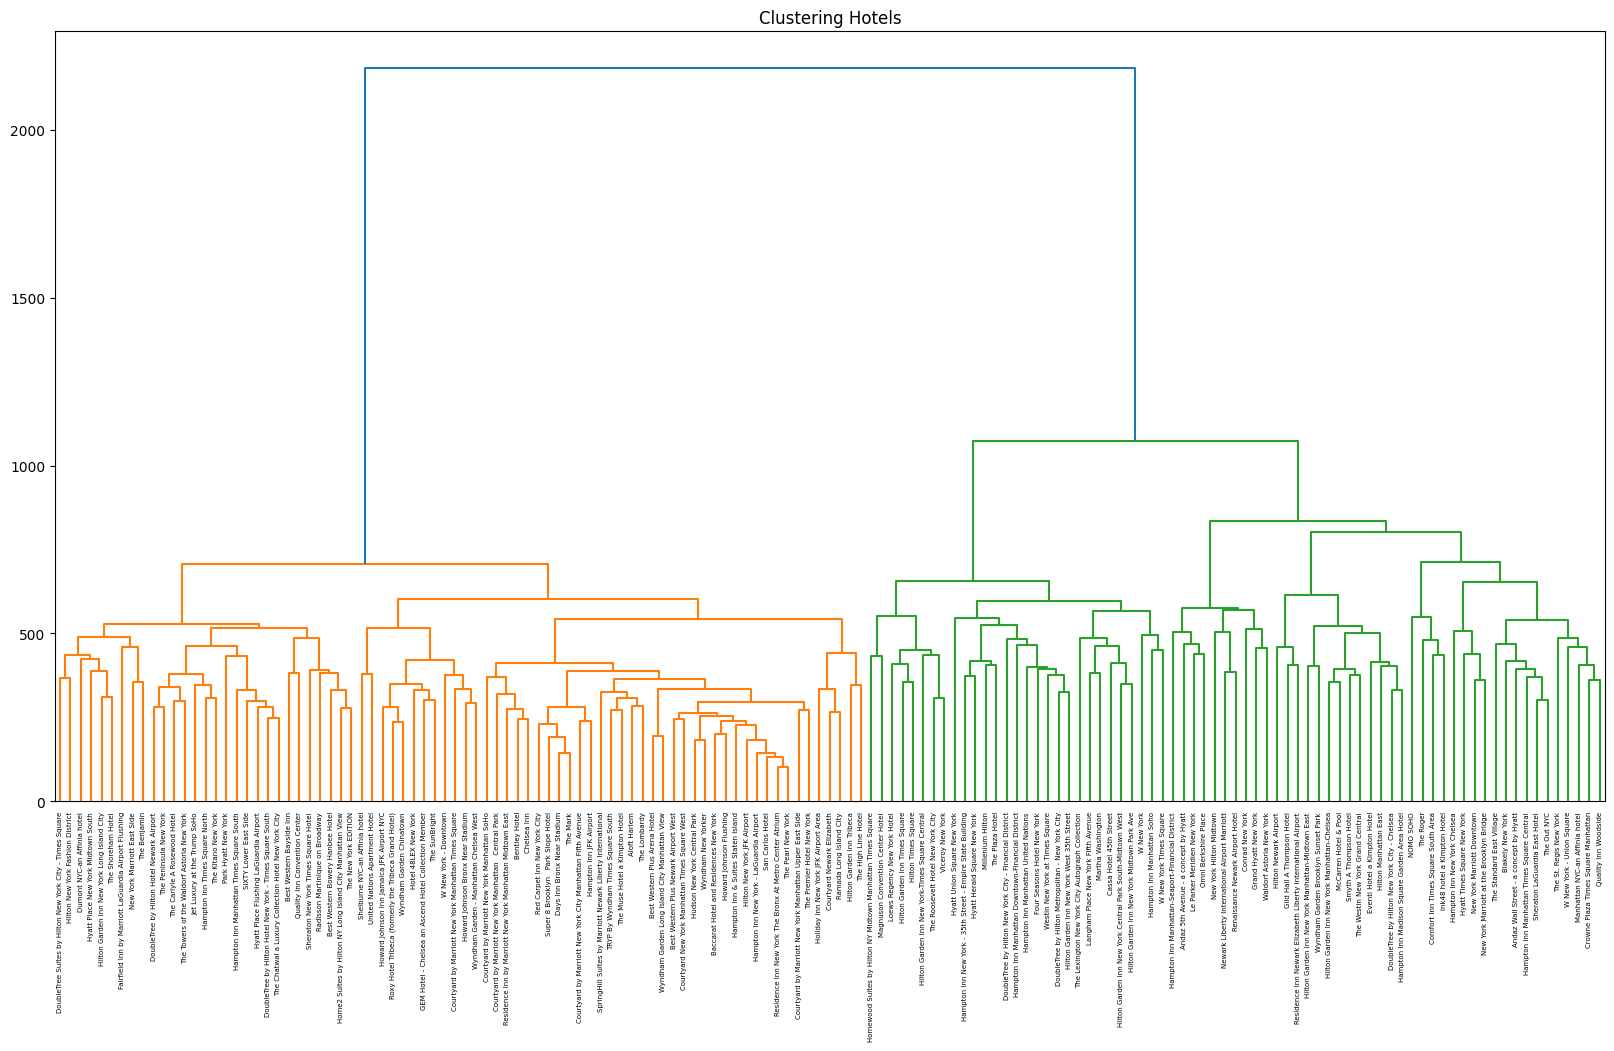

In [18]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from scipy import cluster
shc = cluster.hierarchy

all_hotels_df =  normal_toList.select([normal_toList["Hotel name"]] +  [normal_toList.features[i] for i in range(160)])

vector = all_hotels_df.toPandas()

print (vector[vector["Hotel name"] == "Bentley Hotel"])

labels = vector.values[:,0]
data = vector.values[:,1:160]
plt.figure(figsize=(20, 10))
plt.title("Clustering Hotels")

Z = shc.linkage(data, method='ward')
dend = shc.dendrogram(Z, labels=labels)